In [1]:
using LinearAlgebra
using Distributions
using Plots
default(label="", margin=10Plots.pt)
include("../util.jl")

e (generic function with 1 method)

In [2]:
# True position
pos = [-0.6, 2.4]

2-element Vector{Float64}:
 -0.6
  2.4

In [3]:
# Beacon coordinates
b1 = [0.5, 3.5]
b2 = [0.8, 2.5]
b3 = [2.1, 3.2]

2-element Vector{Float64}:
 2.1
 3.2

In [4]:
function measurements(pos, b1,b2,b3)
    
    r1 = norm(pos - b1,2)
    r2 = norm(pos - b2,2)
    r3 = norm(pos - b3,2)
    
    return [r1,r2,r3]
end

r1,r2,r3 = measurements(pos, b1,b2,b3)

3-element Vector{Float64}:
 1.5556349186104046
 1.40356688476182
 2.816025568065745

In [5]:
function trilateration(r1,r2,r3)
    
    A = (-2*b1[1] + 2*b2[1])
    B = (-2*b1[2] + 2*b2[2])
    C = r1^2 − r2^2 − b1[1]^2 + b2[1]^2 − b1[2]^2 + b2[2]^2
    D = (-2*b2[1] + 2*b3[1])
    E = (-2*b2[2] + 2*b3[2])
    F = r2^2 − r3^2 − b2[1]^2 + b3[1]^2 - b2[2]^2 + b3[2]^2

    x = (C*E - F*B)/(E*A - B*D)
    y = (C*D - A*F)/(B*D - E*A)
    
    return [x,y]
end

pos_est = trilateration(r1,r2,r3)

2-element Vector{Float64}:
 -0.6
  2.4

In [6]:
N = 100
pos_est = zeros(N,2)

for i = 1:100
    
    r1,r2,r3 = measurements(pos, b1,b2,b3) + 1e-1randn(3,)
     
    pos_est[i,:] .= trilateration(r1,r2,r3)
    
end
pos_est

100×2 Matrix{Float64}:
 -0.40553   2.44636
 -0.730115  2.43532
 -0.326571  2.28526
 -0.45519   2.55162
 -0.790546  2.81793
 -0.319636  2.43865
 -0.756415  2.11588
 -0.873159  2.13932
 -0.487672  2.27907
 -0.281831  2.50945
 -0.741993  2.47264
 -0.473694  2.48514
 -0.570348  2.53177
  ⋮         
 -0.400621  2.5271
 -0.611874  2.75217
 -0.585027  2.15863
 -0.369087  2.56982
 -0.7272    2.29972
 -0.686621  2.32694
 -0.435934  2.56775
 -0.683139  2.41801
 -0.255379  2.28063
 -1.10995   2.28755
 -0.525155  2.39942
 -0.580806  2.29454

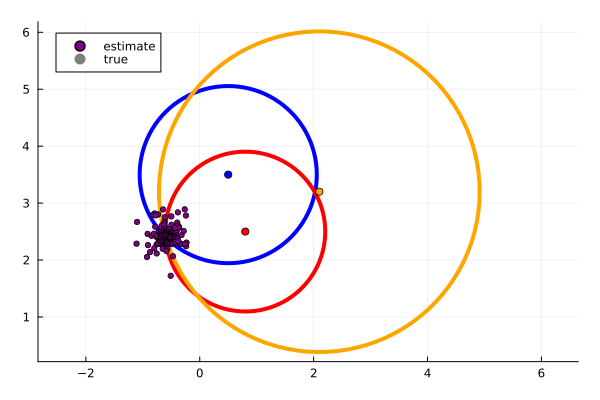

In [7]:
t = range(0.0, stop=2π, length=100)

plot(; aspect_ratio=:equal)

r1 = norm(pos - b1,2)
r2 = norm(pos - b2,2)
r3 = norm(pos - b3,2)

plot!(b1[1] .+ r1*cos.(t), b1[2] .+ r1*sin.(t), lw=4, color="blue")
scatter!([b1[1]], [b1[2]], color="blue")
plot!(b2[1] .+ r2*cos.(t), b2[2] .+ r2*sin.(t), lw=4, color="red")
scatter!([b2[1]], [b2[2]], color="red")
plot!(b3[1] .+ r3*cos.(t), b3[2] .+ r3*sin.(t), lw=4, color="orange")
scatter!([b3[1]], [b3[2]], color="orange")

scatter!(pos_est[:,1], pos_est[:,2], label="estimate", color="purple", markersize=3)

scatter!([pos[1]], [pos[2]], color="black", alpha=0.5, label="true", markersize=10)

### Empirical variance of measurements 

In [8]:
# Compare two random points 

N = 1000
x1 = rand(MvNormal(0.5randn(2), diagm(2e-3ones(2))),N)
y1 = cat([measurements(x1[:,n], b1, b2, b3) for n in 1:N]...,dims=2)
trc1 = det(cov(y1'))

x2 = rand(MvNormal(0.5randn(2), diagm(2e-3ones(2))),N)
y2 = cat([measurements(x2[:,n], b1,b2,b3) for n in 1:N]...,dims=2)
trc2 = det(cov(y2'))

4.257166085967857e-14

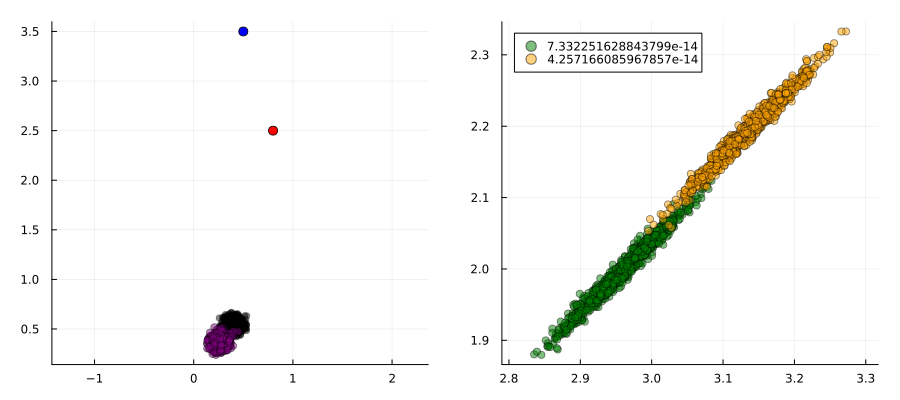

In [9]:
p101 = plot(; aspect_ratio=:equal)
scatter!([b1[1]], [b1[2]], color="blue", markersize=5)
scatter!([b2[1]], [b2[2]], color="red", markersize=5)
scatter!(x1[1,:], x1[2,:], color="black", alpha=0.5, markersize=4)
scatter!(x2[1,:], x2[2,:], color="purple", alpha=0.5, markersize=4)

p102 = plot(; aspect_ratio=:equal)
scatter!(y1[1,:], y1[2,:], color="green", label="$trc1", alpha=0.5, markersize=4)
scatter!(y2[1,:], y2[2,:], color="orange", label="$trc2", alpha=0.5, markersize=4)

plot(p101,p102, layout=grid(1,2), size=(900,400))

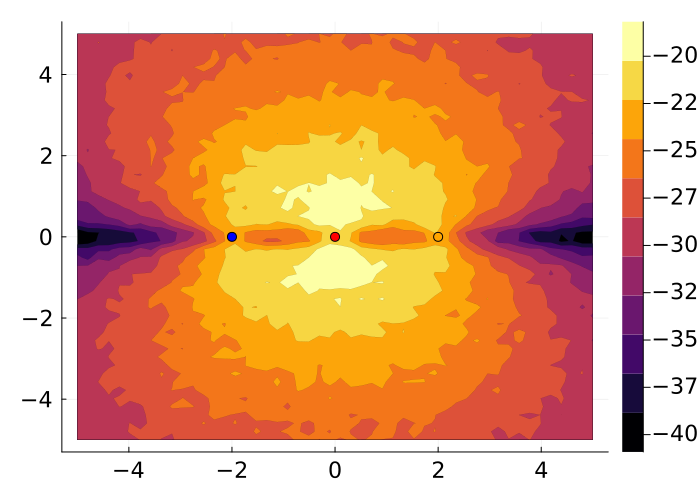

In [24]:
b1 = [-2., 0.]
b2 = [ 0., 0.];
b3 = [ 2., 0.];

num_samples = 100
num_grid = 50
xgrid = range(-5, 5, length=num_grid)
ygrid = range(-5, 5, length=num_grid)

S_grid = diagm(1e-2ones(2))

function helper1(x,y)
    
    state_samples = rand(MvNormal([x,y], S_grid),num_samples)
    angle_samples = cat([measurements(state_samples[:,n], b1, b2, b3) for n in 1:num_samples]...,dims=2)
    return logdet(cov(angle_samples'))
end

contourf(xgrid, ygrid, helper1, levels=10, linewidth=0, tickfontsize=15, size=(700,500))
scatter!([b1[1]], [b1[2]], color="blue", markersize=5)
scatter!([b2[1]], [b2[2]], color="red", markersize=5)
scatter!([b3[1]], [b3[2]], color="orange", markersize=5)

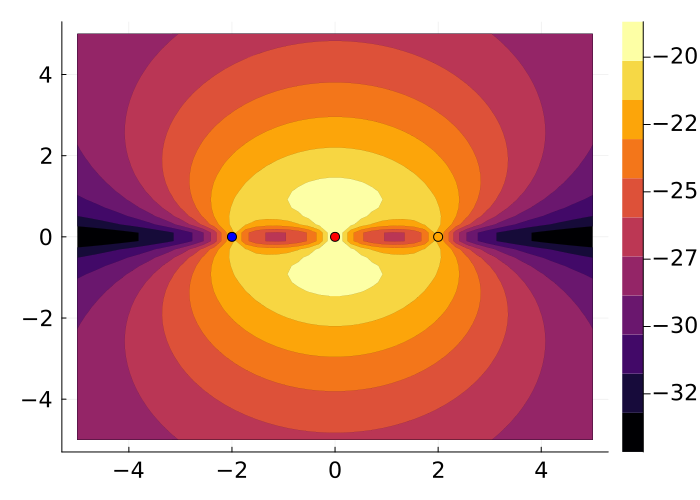

In [25]:
function helper2(x,y)
    _, Σ, _ = ET2([x,y], S_grid, a->measurements(a, b1, b2, b3), addmatrix=1e-8diagm(ones(3)))
    return logdet(Σ)
end
    
contourf(xgrid, ygrid, helper2, levels=10, linewidth=0, tickfontsize=15, size=(700,500))
scatter!([b1[1]], [b1[2]], color="blue", markersize=5)
scatter!([b2[1]], [b2[2]], color="red", markersize=5)
scatter!([b3[1]], [b3[2]], color="orange", markersize=5)